In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
# from imblearn.under_sampling import SMOTE, RandomOverSampler

df= pd.read_csv('bank-additional-full.csv', sep=';', encoding='utf-8')
# Results for all clients
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
#Categorising ages into bins
bins = [0,20,40,60,80,100]
labels = ['1-20','21-40','41-60','61-80','81-100']
df['age_bin']=pd.cut(df['age'], bins=bins, labels=labels)

#Set max values 
df['campaign']=df['campaign'].apply(lambda x: min(4, x))

#Applying one hot encoding to categorical columns
df=pd.get_dummies(df,columns=['age_bin'], dtype=int)
df=pd.get_dummies(df, columns=['job'], dtype=int)
df= pd.get_dummies(df, columns=['marital'], dtype=int)
df= pd.get_dummies(df, columns=['education'], dtype=int)
df= pd.get_dummies(df, columns=['default'], dtype=int)
df= pd.get_dummies(df, columns=['housing'], dtype=int)
df= pd.get_dummies(df, columns=['loan'], dtype=int)
df= pd.get_dummies(df, columns=['contact'], dtype=int)
df= pd.get_dummies(df, columns=['month'], dtype=int)
df= pd.get_dummies(df, columns=['day_of_week'], dtype=int)
# df= pd.get_dummies(df, columns=['campaign'], dtype=int)
df= pd.get_dummies(df, columns=['poutcome'], dtype=int)


#Replacing negative values to zero
df['emp.var.rate']=df['emp.var.rate'].apply(lambda x: max(0, x))
df['cons.conf.idx']=df['cons.conf.idx'].apply(lambda x: max(0, x))

#One hot encoding of 'y' column
df['y']=df['y'].replace({'yes':1,'no':0})

#Dropping column
df = df.drop('duration', axis=1)
df = df.drop('age',axis=1)
df = df.drop('age_bin_61-80',axis=1)
df = df.drop('age_bin_1-20',axis=1)
df = df.drop('age_bin_81-100',axis=1)
df = df.drop('job_unknown',axis=1)
df = df.drop('marital_unknown',axis=1)
df = df.drop('education_unknown',axis=1)
df = df.drop('default_unknown',axis=1)
df = df.drop('housing_unknown',axis=1)
df = df.drop('loan_unknown',axis=1)
# df=df.drop('emp.var.rate',axis=1)
# df=df.drop('cons.price.idx',axis=1)
# df=df.drop('cons.conf.idx',axis=1)
# df=df.drop('euribor3m',axis=1)
# df=df.drop('nr.employed',axis=1)

#Replacing values
# df['pdays']=df['pdays'].replace({999:0})

#Rearranging columns
cols = list(df.columns)
cols.remove('y')           
cols.insert(cols.index('poutcome_success') + 1, 'y')  

# Reorder dataframe
df = df[cols]

/var/folders/3t/kqzykkfx49d7ljggm3b2fc3m0000gn/T/ipykernel_2748/3306751810.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y']=df['y'].replace({'yes':1,'no':0})


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   campaign                       41188 non-null  int64  
 1   pdays                          41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  int64  
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   age_bin_21-40                  41188 non-null  int64  
 9   age_bin_41-60                  41188 non-null  int64  
 10  job_admin.                     41188 non-null  int64  
 11  job_blue-collar                41188 non-null  int64  
 12  job_entrepreneur               41188 non-null 

In [4]:
# Define x and y
x=df.iloc[:,0:57]
y=df.iloc[:,-1]

# Select top 3 features
best_features=SelectKBest(score_func=chi2,k=3)
fit=best_features.fit(x,y)

# Create data frames for the features and the score of each feature
df_scores=pd.DataFrame(fit.scores_)
df_columns=pd.DataFrame(x.columns)

# Combine all the features and their correspionding scores in one data frame
features_scores=pd.concat([df_columns,df_scores], axis=1)
features_scores.columns=['Features','Score']
features_scores.sort_values(by='Score').tail(50)

,Features,Score
19,job_technician,1.302220
53,day_of_week_wed,1.312743
49,day_of_week_fri,1.632960
13,job_housemaid,1.697982
27,education_high.school,1.759105
52,day_of_week_tue,2.142779
28,education_illiterate,2.161724
34,housing_yes,2.704428
40,month_aug,2.718956
4,cons.price.idx,2.736151


In [5]:
x= df.drop(['y'], axis=1)  # Features
y= df['y']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [6]:
logregmodel=LogisticRegression()
logregmodel.fit(x_train,y_train)

y_pred_logreg=logregmodel.predict(x_test)
print(x_test)
print(y_pred_logreg)

       campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32884         1    999         1           0.0          92.893              0   
3169          2    999         0           1.1          93.994              0   
32206         1    999         1           0.0          92.893              0   
9403          4    999         0           1.4          94.465              0   
14020         2    999         0           1.4          93.918              0   
...         ...    ...       ...           ...             ...            ...   
12322         1    999         0           1.4          93.918              0   
23440         4    999         0           1.4          93.444              0   
29431         4    999         1           0.0          93.075              0   
16627         2    999         0           1.4          93.918              0   
1871          2    999         0           1.1          93.994              0   

       euribor3m  nr.employ

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
print('Logistic Regression:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_logreg))
print('Recall: ',metrics.recall_score(y_test, y_pred_logreg, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_logreg, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_logreg, zero_division=1))
accuracy_log=metrics.accuracy_score(y_test, y_pred_logreg)

Logistic Regression:
Accuracy:  0.8973051711580481
Recall:  0.22139037433155082
Precision:  0.6369230769230769
CL Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.64      0.22      0.33       935

    accuracy                           0.90      8238
   macro avg       0.77      0.60      0.64      8238
weighted avg       0.88      0.90      0.87      8238



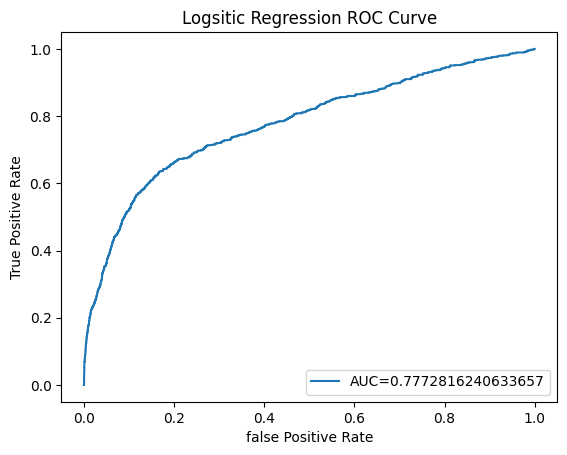

In [8]:
y_pred_proba= logregmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Logsitic Regression ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [9]:
rfcmodel = RandomForestClassifier()
rfcmodel.fit(x_train, y_train)

y_pred_rfc=rfcmodel.predict(x_test)
print(x_test)
print(y_pred_rfc)

       campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32884         1    999         1           0.0          92.893              0   
3169          2    999         0           1.1          93.994              0   
32206         1    999         1           0.0          92.893              0   
9403          4    999         0           1.4          94.465              0   
14020         2    999         0           1.4          93.918              0   
...         ...    ...       ...           ...             ...            ...   
12322         1    999         0           1.4          93.918              0   
23440         4    999         0           1.4          93.444              0   
29431         4    999         1           0.0          93.075              0   
16627         2    999         0           1.4          93.918              0   
1871          2    999         0           1.1          93.994              0   

       euribor3m  nr.employ

In [10]:
print('Random Forest Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rfc))
print('Recall: ',metrics.recall_score(y_test, y_pred_rfc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_rfc, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_rfc, zero_division=1))
accuracy_rfc=metrics.accuracy_score(y_test, y_pred_rfc)

Random Forest Classifier:
Accuracy:  0.8896576839038601
Recall:  0.30053475935828877
Precision:  0.5242537313432836
CL Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7303
           1       0.52      0.30      0.38       935

    accuracy                           0.89      8238
   macro avg       0.72      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238



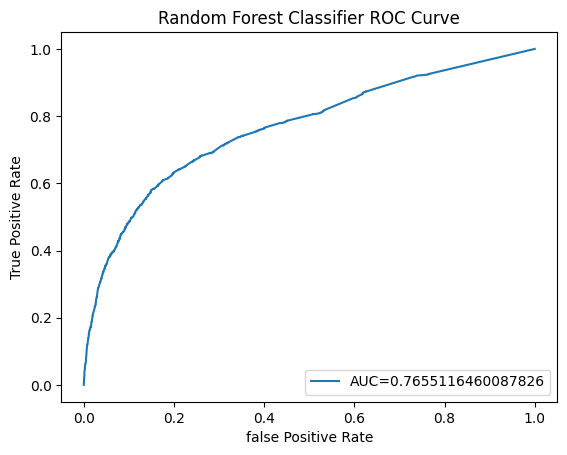

In [11]:
y_pred_proba= rfcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Random Forest Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [12]:
dtcmodel = DecisionTreeClassifier()
dtcmodel.fit(x_train, y_train)

y_pred_dtc=dtcmodel.predict(x_test)
print(x_test)
print(y_pred_dtc)

       campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32884         1    999         1           0.0          92.893              0   
3169          2    999         0           1.1          93.994              0   
32206         1    999         1           0.0          92.893              0   
9403          4    999         0           1.4          94.465              0   
14020         2    999         0           1.4          93.918              0   
...         ...    ...       ...           ...             ...            ...   
12322         1    999         0           1.4          93.918              0   
23440         4    999         0           1.4          93.444              0   
29431         4    999         1           0.0          93.075              0   
16627         2    999         0           1.4          93.918              0   
1871          2    999         0           1.1          93.994              0   

       euribor3m  nr.employ

In [13]:
print('Decision Tree Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_dtc))
print('Recall: ',metrics.recall_score(y_test, y_pred_dtc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_dtc, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_dtc, zero_division=1))
accuracy_dtc=metrics.accuracy_score(y_test, y_pred_dtc)

Decision Tree Classifier:
Accuracy:  0.8472930322893907
Recall:  0.332620320855615
Precision:  0.3291005291005291
CL Report: 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      7303
           1       0.33      0.33      0.33       935

    accuracy                           0.85      8238
   macro avg       0.62      0.62      0.62      8238
weighted avg       0.85      0.85      0.85      8238



In [14]:
nbmodel = MultinomialNB()
nbmodel.fit(x_train, y_train)

y_pred_nb=nbmodel.predict(x_test)
print(x_test)
print(y_pred_nb)

       campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
32884         1    999         1           0.0          92.893              0   
3169          2    999         0           1.1          93.994              0   
32206         1    999         1           0.0          92.893              0   
9403          4    999         0           1.4          94.465              0   
14020         2    999         0           1.4          93.918              0   
...         ...    ...       ...           ...             ...            ...   
12322         1    999         0           1.4          93.918              0   
23440         4    999         0           1.4          93.444              0   
29431         4    999         1           0.0          93.075              0   
16627         2    999         0           1.4          93.918              0   
1871          2    999         0           1.1          93.994              0   

       euribor3m  nr.employ

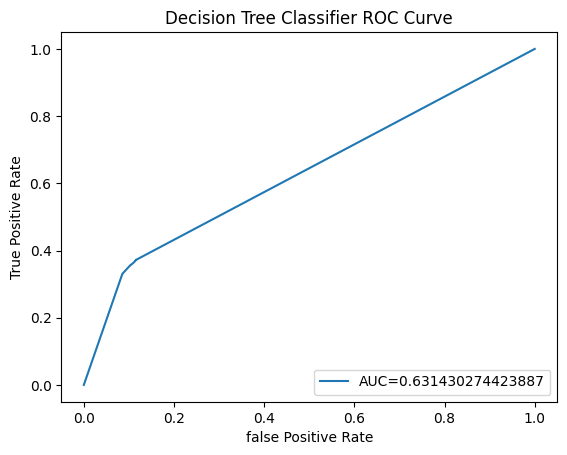

In [15]:
y_pred_proba= dtcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Decision Tree Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [16]:
print('Naive Bayes:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_nb))
print('Recall: ',metrics.recall_score(y_test, y_pred_nb, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_nb, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_nb, zero_division=1))
accuracy_nb=metrics.accuracy_score(y_test, y_pred_nb)

Naive Bayes:
Accuracy:  0.8947560087399854
Recall:  0.20320855614973263
Precision:  0.6089743589743589
CL Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.61      0.20      0.30       935

    accuracy                           0.89      8238
   macro avg       0.76      0.59      0.62      8238
weighted avg       0.87      0.89      0.87      8238



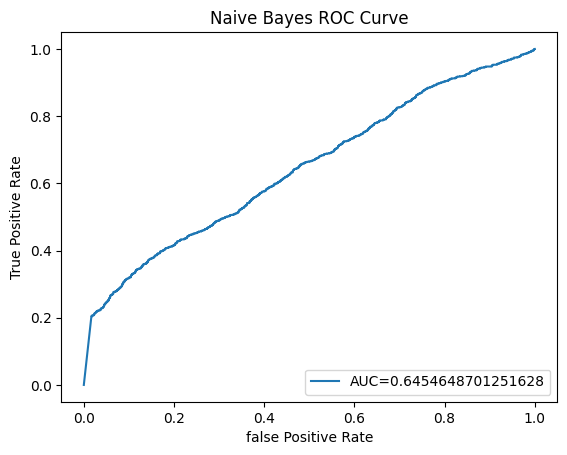

In [17]:
y_pred_proba= nbmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Naive Bayes ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

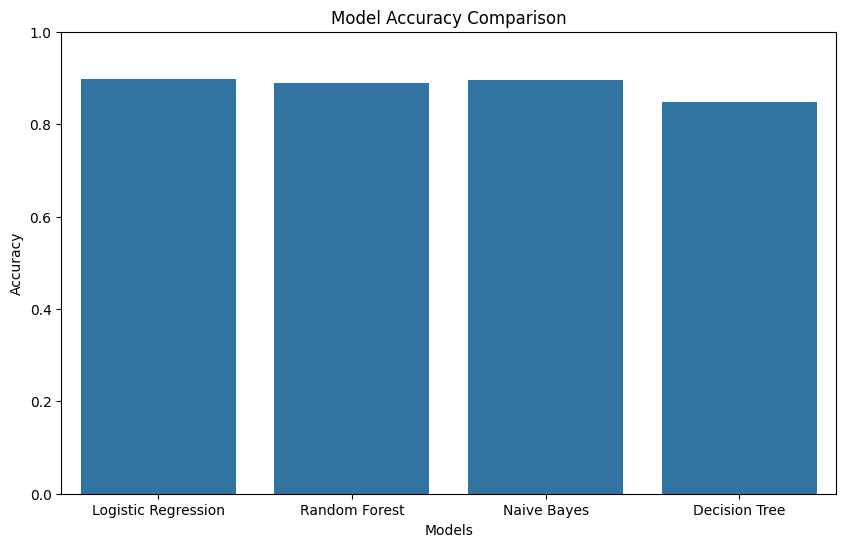

In [18]:
#visualise the results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree'], 
            y=[accuracy_log, accuracy_rfc, accuracy_nb, accuracy_dtc])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-
plt.show()

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-lear

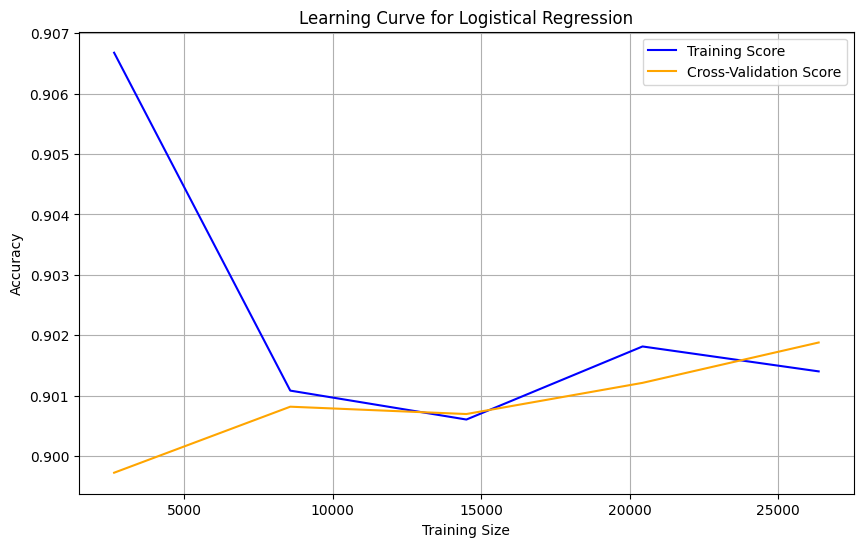

In [19]:
#learning curve for logistic regression
train_sizes, train_scores, test_scores = learning_curve(logregmodel, x_train, y_train
, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange')

plt.title('Learning Curve for Logistical Regression')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
record=df.sample(n=1, random_state=100)
record=tuple(record.values.tolist()[0])
record=tuple(record[:-1])
record

(1.0,
 999.0,
 0.0,
 0.0,
 92.893,
 0.0,
 1.291,
 5099.1,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0)

In [21]:
prediction = logregmodel.predict([(30.0,1.0,0.0,1.0,0.0,92.893,0.0,1.299,5099.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0)])
prediction

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 62 features, but LogisticRegression is expecting 57 features as input.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  int64  
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   job_admin.                     41188 non-null  int64  
 10  job_blue-collar                41188 non-null  int64  
 11  job_entrepreneur               41188 non-null  int64  
 12  job_housemaid                  41188 non-null 